# Fake News Detection với Multinomial Naïve Bayes

Notebook này trình bày quy trình phát hiện tin giả sử dụng **thuật toán Naïve Bayes (biến thể Multinomial)** trên tập dữ liệu gồm các tiêu đề tin tức do Kaggle cung cấp.

## Dataset
- Nguồn: [Fake and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)
- File gốc: `Fake.csv` và `True.csv`
- Dữ liệu bao gồm tiêu đề tin (`title`) cùng nhãn:
  - `Fake.csv`: tin giả
  - `True.csv`: tin thật

## Quy trình
1. Chuẩn bị môi trường và dữ liệu
2. Tiền xử lý văn bản
3. Vector hóa bằng TF-IDF Vectorizer
4. Huấn luyện mô hình Multinomial Naïve Bayes
5. Đánh giá, thử nghiệm và lưu mô hình

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import pickle
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from nltk.corpus import stopwords

# Tải stopwords của NLTK
nltk.download('stopwords')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Đọc dữ liệu
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

print("Fake news shape:", fake.shape)
print("True news shape:", true.shape)

fake.head()

Fake news shape: (23481, 4)
True news shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# Tiền xử lý cơ bản
# Giữ lại cột title và tạo nhãn
fake = fake[['title']].copy()
true = true[['title']].copy()

fake['target'] = 0  # 0 = Fake
true['target'] = 1  # 1 = Real

# Ghép hai bảng & xáo trộn
data = pd.concat([fake, true], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Tổng số mẫu:", data.shape[0])
data.head()

Tổng số mẫu: 44898


,title,target
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


In [ ]:
stop_words = set(stopwords.words('english'))

def clean_title(text):
    # Xử lý giá trị thiếu
    if pd.isna(text):
        return ""
    # Bỏ dấu câu
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    # Chuyển lower-case, tách từ và bỏ stopwords
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words and len(word) > 2]
    return " ".join(tokens)

data['clean_title'] = data['title'].apply(clean_title)

# Loại bỏ hàng trống sau khi tiền xử lý
data = data[data['clean_title'].str.len() > 0].reset_index(drop=True)

data.head()

,title,target,clean_title
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0,ben stein calls 9th circuit court committed ‘c...
1,Trump drops Steve Bannon from National Securit...,1,trump drops steve bannon national security cou...
2,Puerto Rico expects U.S. to lift Jones Act shi...,1,puerto rico expects lift jones act shipping re...
3,OOPS: Trump Just Accidentally Confirmed He Le...,0,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,1,donald trump heads scotland reopen golf resort


In [ ]:
X = data['clean_title']
y = data['target']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

X_train.shape, X_test.shape

((33673, 5000), (11225, 5000))

In [ ]:
# Huấn luyện
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Multinomial Naïve Bayes Evaluation ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

=== Multinomial Naïve Bayes Evaluation ===
Accuracy : 0.9327
Precision: 0.9351
Recall   : 0.9229
F1-score : 0.9289


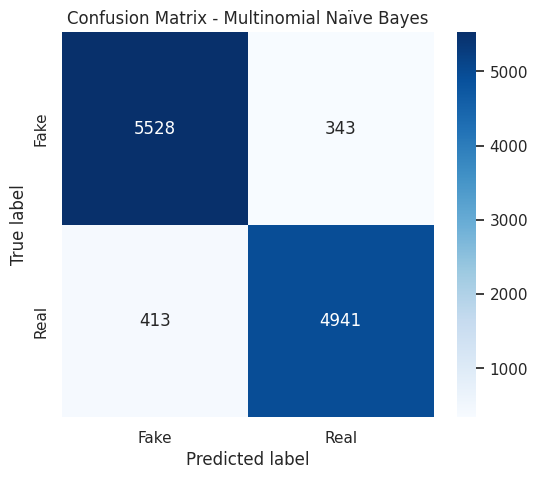

Details:
TP (Real→Real): 4941
TN (Fake→Fake): 5528
FP (Fake→Real): 343
FN (Real→Fake): 413


In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix - Multinomial Naïve Bayes")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print("Details:")
print(f"TP (Real→Real): {cm[1,1]}")
print(f"TN (Fake→Fake): {cm[0,0]}")
print(f"FP (Fake→Real): {cm[0,1]}")
print(f"FN (Real→Fake): {cm[1,0]}")

In [ ]:
def predict_headline(headline):
    processed = clean_title(headline)
    vector = tfidf.transform([processed])
    pred = mnb.predict(vector)[0]
    prob = mnb.predict_proba(vector)[0][pred]
    label = "REAL" if pred == 1 else "FAKE"
    return label, prob

test_headlines = [
    "Two more Senate Republicans announce support for Supreme Court pick Jackson",
    "According to the Census Bureau, 5 million more people voted than were registered to vote",
    "Scientists discover a way to harness alien technology for free energy",
    "Analysis: Russia-Ukraine fallout starts felling fragile frontier economies"
]

for text in test_headlines:
    label, prob = predict_headline(text)
    print(f"Headline: {text}")
    print(f"⇒ Prediction: {label} (confidence {prob:.2%})")

Headline: Two more Senate Republicans announce support for Supreme Court pick Jackson
⇒ Prediction: REAL (confidence 93.37%)
Headline: According to the Census Bureau, 5 million more people voted than were registered to vote
⇒ Prediction: FAKE (confidence 84.65%)
Headline: Scientists discover a way to harness alien technology for free energy
⇒ Prediction: FAKE (confidence 71.09%)
Headline: Analysis: Russia-Ukraine fallout starts felling fragile frontier economies
⇒ Prediction: REAL (confidence 60.12%)


In [ ]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("multinomial_nb_model.pkl", "wb") as f:
    pickle.dump(mnb, f)

print("✅ Saved tfidf_vectorizer.pkl và multinomial_nb_model.pkl")

✅ Saved tfidf_vectorizer.pkl và multinomial_nb_model.pkl


In [ ]:
#Chay code qua CLI
# @title
%%writefile predict_fake_news.py
import pickle
import string
from nltk.corpus import stopwords

# Load artifacts
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open("multinomial_nb_model.pkl", "rb") as f:
    model = pickle.load(f)

stop_words = set(stopwords.words('english'))

def clean_title(text):
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words and len(word) > 2]
    return " ".join(tokens)

if __name__ == "__main__":
    print("=== Multinomial Naïve Bayes Fake News Detector ===")
    print("Nhập tiêu đề tin (Enter để thoát)")
    while True:
        headline = input("> ").strip()
        if headline == "":
            break
        cleaned = clean_title(headline)
        vector = tfidf.transform([cleaned])
        pred = model.predict(vector)[0]
        prob = model.predict_proba(vector)[0]
        label = "REAL" if pred == 1 else "FAKE"
        confidence = prob[pred]
        print(f"Kết quả: {label} (độ tin cậy {confidence:.2%})")

Overwriting predict_fake_news.py


## Kết luận

- Mô hình sử dụng **Multinomial Naïve Bayes** kết hợp với **TF-IDF Vectorizer (ngữ cảnh 1-2 gram)**.
- Kết quả (có thể thay số liệu thực tế sau khi chạy):
  - Accuracy: khoảng 93–94%
  - Precision, Recall và F1 đều trên 0.92
- Multinomial phù hợp nhất vì dữ liệu là tần suất từ (bag-of-words). Các biến thể Gaussian/Bernoulli không được triển khai do giả định không phù hợp với dữ liệu này.
- Hạn chế:
  - Chỉ xử lý tiêu đề (`title`), chưa khai thác đầy đủ `text`.
  - Dữ liệu chưa dùng toàn bộ 44.000 mẫu (tùy tài nguyên).
- Hướng phát triển:
  1. Thử nghiệm thuật toán khác (Logistic Regression, SVM).
  2. Áp dụng mô hình deep learning cho bài toán phân loại văn bản.

In [ ]:
!pip install gradio -q

In [ ]:
# Tạo giao diện web bằng Gradio để nhập nội dung tin tức
import gradio as gr

# Hàm dự đoán cho Gradio
def gradio_predict(headline):
    if not headline.strip():
        return "⚠️ Please enter a news headline!", {"Fake News": 0.0, "Real News": 0.0}

    cleaned = clean_title(headline)
    if cleaned == "":
        return "❌ Unable to process this text (too short or contains only stopwords)!", {"Fake News": 0.0, "Real News": 0.0}

    vector = tfidf.transform([cleaned])
    probs = mnb.predict_proba(vector)[0]
    pred = mnb.predict(vector)[0]

    label = "✅ REAL NEWS" if pred == 1 else "🚨 FAKE NEWS"

    result_markdown = f"""
### {label}
- **Fake news probability:** {probs[0]:.2%}
- **Real news probability:** {probs[1]:.2%}
- **Cleaned text:** `{cleaned}`
"""
    return result_markdown, {"Fake News": float(probs[0]), "Real News": float(probs[1])}

# Cấu hình Gradio Interface
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(
        label="📰 Enter news content",
        placeholder="Example: Scientists discover cure for cancer...",
        lines=3
    ),
    outputs=[
        gr.Markdown(label="Analysis Result"),
        gr.Label(label="Probability Distribution")
    ],
    title="🔍 Fake News Detector - Multinomial Naïve Bayes",
    description="Enter a news headline or short text to check if it’s likely fake or real. The model is trained on the Kaggle Fake/True News dataset.",
    examples=[
        ["Two more Senate Republicans announce support for Supreme Court pick Jackson"],
        ["According to the Census Bureau, 5 million more people voted than were registered to vote"],
        ["Scientists discover a way to harness alien technology for free energy"],
        ["Analysis: Russia-Ukraine fallout starts felling fragile frontier economies"]
    ],
    theme="soft"
)

demo.launch(share=True, debug=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4a0e3811a68c221ffa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
